In [1]:
!hostnamectl

   Static hostname: psh01com1hcom38
         Icon name: computer-server
           Chassis: server
        Machine ID: 4232d1115a5548e982021ba5a27af5c3
           Boot ID: 6109cd0ab7e442278059169e69c9162d
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


## Load Packages

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dev.notebooks.plotting as dev_plots
from typing import Union
import importlib
import grn_inference.utils as utils

base_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/"
ground_truth_dir = os.path.join(base_dir, "ground_truth_files")
cache_folder = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/sliding_window_calculation_method_testing_cache"

## Reload Package

In [233]:
importlib.reload(utils)
importlib.reload(dev_plots)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

## Load ChIP-Atlas Ground Truth

In [ ]:
# Load in the TF-peak-nearest gene TSS distance ChIP-Atlas edge file
chip_atlas_edges_full = pd.read_csv(os.path.join(ground_truth_dir, "chip_atlas_tf_peak_tg_dist.csv"), header=0, index_col=None)
chip_atlas_edges_full = chip_atlas_edges_full[["source_id", "peak_id", "target_id", "distance"]]
chip_atlas_edges_full["source_id"] = chip_atlas_edges_full["source_id"].str.capitalize()
chip_atlas_edges_full["target_id"] = chip_atlas_edges_full["target_id"].str.capitalize()

## Sliding Window Scores

### Load ChIP-Atlas Sliding Window Scores

In [4]:
chipseq_output_dir = os.path.join(base_dir, "output/chipseq_sliding_window")
chipseq_sliding_window_df = pd.read_parquet(os.path.join(chipseq_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")
chipseq_sliding_window_df

,peak_id,source_id,sliding_window_score
0,chr17:46704666-46705502,Ascl1,18836.157784
1,chr17:3456010-3456318,Ascl1,6543.452178
2,chr17:56255512-56256229,Ascl1,15508.133754
3,chr17:69382560-69382744,Ascl1,4256.191542
4,chr17:86555341-86555555,Ascl1,4312.891574
...,...,...,...
86068,chr11:51936197-51936397,Zfp335,7371.634079
86069,chr11:100846598-100846664,Zfp335,2121.398070
86070,chr11:108891288-108891643,Zfp335,13014.262983
86071,chr11:87771063-87771282,Zfp335,8039.550073


### Merge Sliding Window Scores with Ground Truth

In [54]:
# Merge the sliding window score TF-peak edges with the ChIP-Atlas edges
sliding_window_chipatlas_merged_df = pd.merge(chipseq_sliding_window_df, chip_atlas_edges_full, on="peak_id", how="inner")
sliding_window_chipatlas_merged_df = sliding_window_chipatlas_merged_df.rename(columns={"source_id_x": "sliding_window_source_id", "source_id_y": "chip_atlas_source_id"})

# Create a "peak_length" column containing the length in bp for each peak genomic range
sliding_window_chipatlas_merged_df["peak_length"] = utils.find_peak_length(peak_id_col=sliding_window_chipatlas_merged_df["peak_id"])

# Create a "label" column with 1 if the TF-peak edges match between score and ground truth df else 0
sliding_window_chipatlas_merged_df["label"] = sliding_window_chipatlas_merged_df.apply(lambda x: 1 if x.sliding_window_source_id == x.chip_atlas_source_id else 0, axis=1)

sliding_window_chipatlas_merged_df.head()

,peak_id,sliding_window_source_id,sliding_window_score,chip_atlas_source_id,target_id,distance,peak_length,label
0,chr17:46704666-46705502,Ascl1,18836.157784,Smarca4,Ppp2r5d,0,836,0
1,chr17:46704666-46705502,Ascl1,18836.157784,Smarca4,Ppp2r5d,0,836,0
2,chr17:3456010-3456318,Ascl1,6543.452178,Ctcf,Tiam2,25996,308,0
3,chr17:56255512-56256229,Ascl1,15508.133754,Ctcf,Fem1a,563,717,0
4,chr17:69382560-69382744,Ascl1,4256.191542,Ctcf,Zbtb14,430,184,0


## Homer Scores

### Load ChIP-Atlas Homer Scores

In [ ]:
homer_results = pd.read_parquet(os.path.join(base_dir, "output/chipseq_homer/homer_tf_to_peak.parquet"), engine="pyarrow")
homer_results = homer_results.reset_index(drop=True)
homer_results["source_id"] = homer_results["source_id"].str.capitalize()
homer_results["homer_binding_score"] = utils.minmax_norm_col(homer_results["homer_binding_score"])
homer_results.head()

In [197]:
homer_sampled = homer_results.sample(n=10_000_000)

### Merge Homer Scores with Ground Truth

In [198]:
# Merge the sliding window score TF-peak edges with the ChIP-Atlas edges
homer_chipatlas_merged_df = pd.merge(homer_sampled, chip_atlas_edges_full, on="peak_id", how="inner")
homer_chipatlas_merged_df = homer_chipatlas_merged_df.rename(columns={"source_id_x": "homer_source_id", "source_id_y": "chip_atlas_source_id"})

# Create a "peak_length" column containing the length in bp for each peak genomic range
homer_chipatlas_merged_df["peak_length"] = utils.find_peak_length(peak_id_col=homer_chipatlas_merged_df["peak_id"])

# Create a "label" column with 1 if the TF-peak edges match between score and ground truth df else 0
homer_chipatlas_merged_df["label"] = homer_chipatlas_merged_df.apply(lambda x: 1 if x.homer_source_id == x.chip_atlas_source_id else 0, axis=1)
homer_chipatlas_merged_df.head()

,peak_id,homer_source_id,homer_binding_score,chip_atlas_source_id,target_id,distance,peak_length,label
0,chr11:88197080-88197532,Gata1,0.001241,Ctcf,Mrps23,2975,452,0
1,chr11:88197080-88197532,Gata1,0.001241,Ctcf,Mrps23,2975,452,0
2,chr2:4917507-4917945,Elf4,0.000459,Ctcf,Phyh,1050,438,0
3,chr5:140847211-140847538,Ctcf,0.000223,Ctcf,Gna12,16780,327,1
4,chr18:69910698-69910930,Six2,0.000956,Six2,Ccdc68,14628,232,1


In [199]:
selected_df = homer_chipatlas_merged_df
selected_score_col="homer_binding_score"
selected_method_name="Homer"
selected_method_tf_col="homer_source_id"

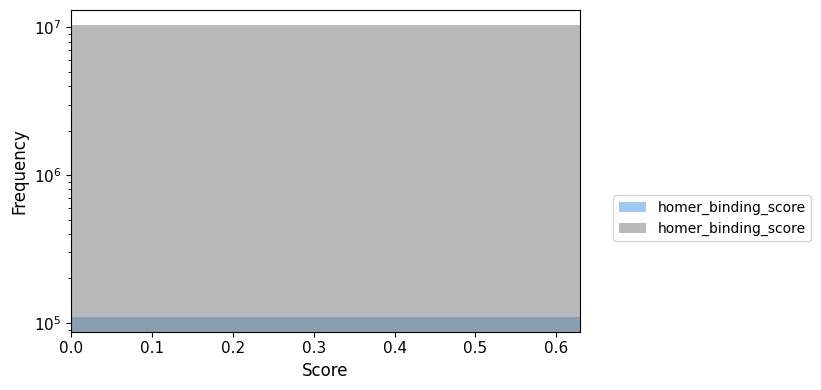

In [217]:
fig = dev_plots.plot_true_false_distribution(
    true_series=selected_df[selected_df["label"] == 1][selected_score_col],
    false_series=selected_df[selected_df["label"] == 0][selected_score_col],
    balance=False,
    log=True
)
fig.show()

INFO: Limiting to scores from the top 40 TFs, found 40


100%|██████████| 40/40 [00:15<00:00,  2.59it/s]                                                                                                                                                                                                    


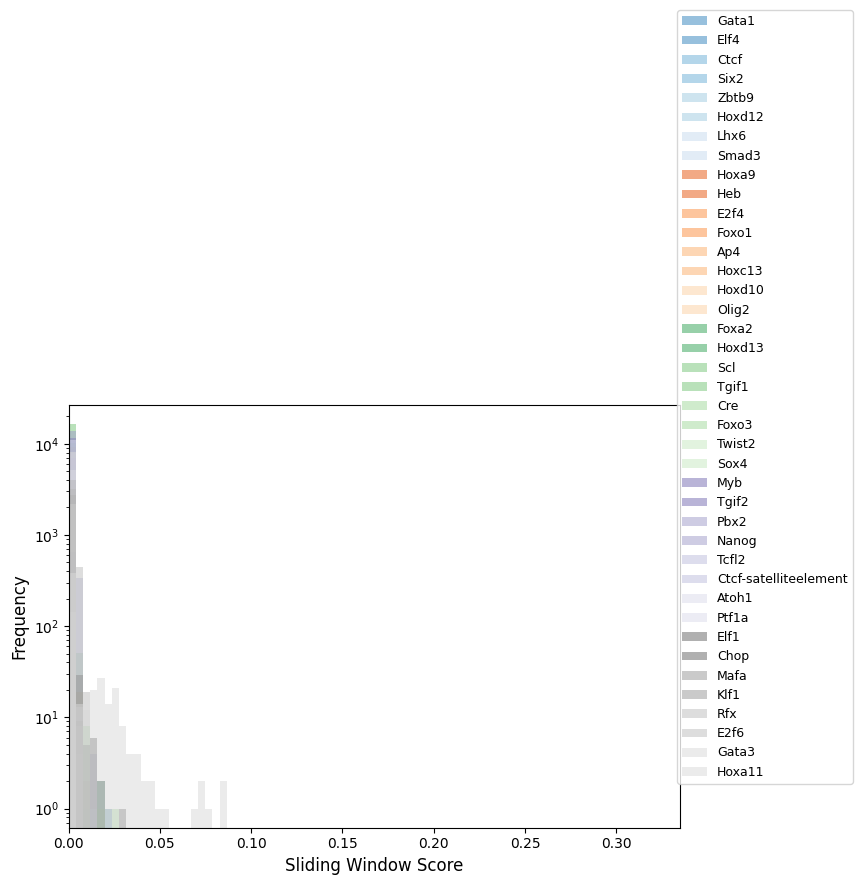

AttributeError: 'NoneType' object has no attribute 'show'

In [218]:
fig = dev_plots.plot_score_distribution_by_tf(
    selected_df, 
    score_col=selected_score_col, 
    tf_col_name=selected_method_tf_col, 
    tfs_of_interest=selected_df[selected_method_tf_col].unique(), 
    log=True)
fig.show()

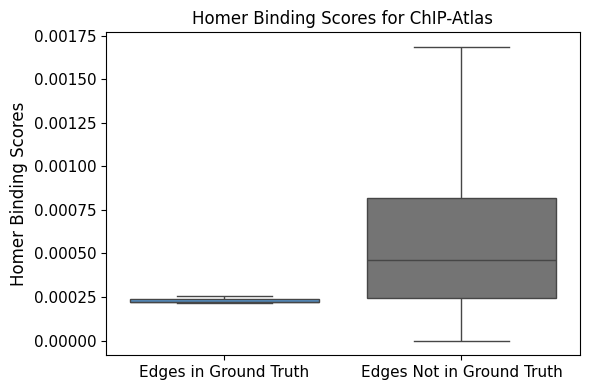

In [200]:
fig = dev_plots.plot_true_false_boxplots(
    df=selected_df,
    score_col=selected_score_col,
    xlabel=None,
    ylabel=f"{selected_method_name} Binding Scores",
    title=f"{selected_method_name} Binding Scores for ChIP-Atlas"
)

fig.show()

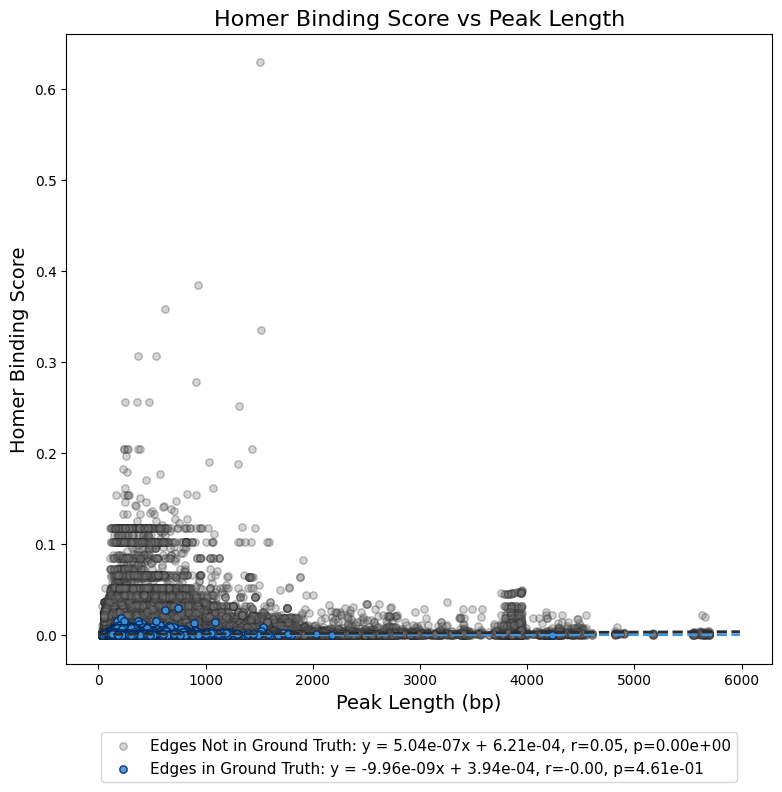

In [201]:
fig = dev_plots.plot_peak_length_vs_score_scatterplot(
    df=selected_df,
    score_col=selected_score_col,
    title=f"{selected_method_name} Binding Score vs Peak Length",
    ylabel=f"{selected_method_name} Binding Score"
)
fig.show()

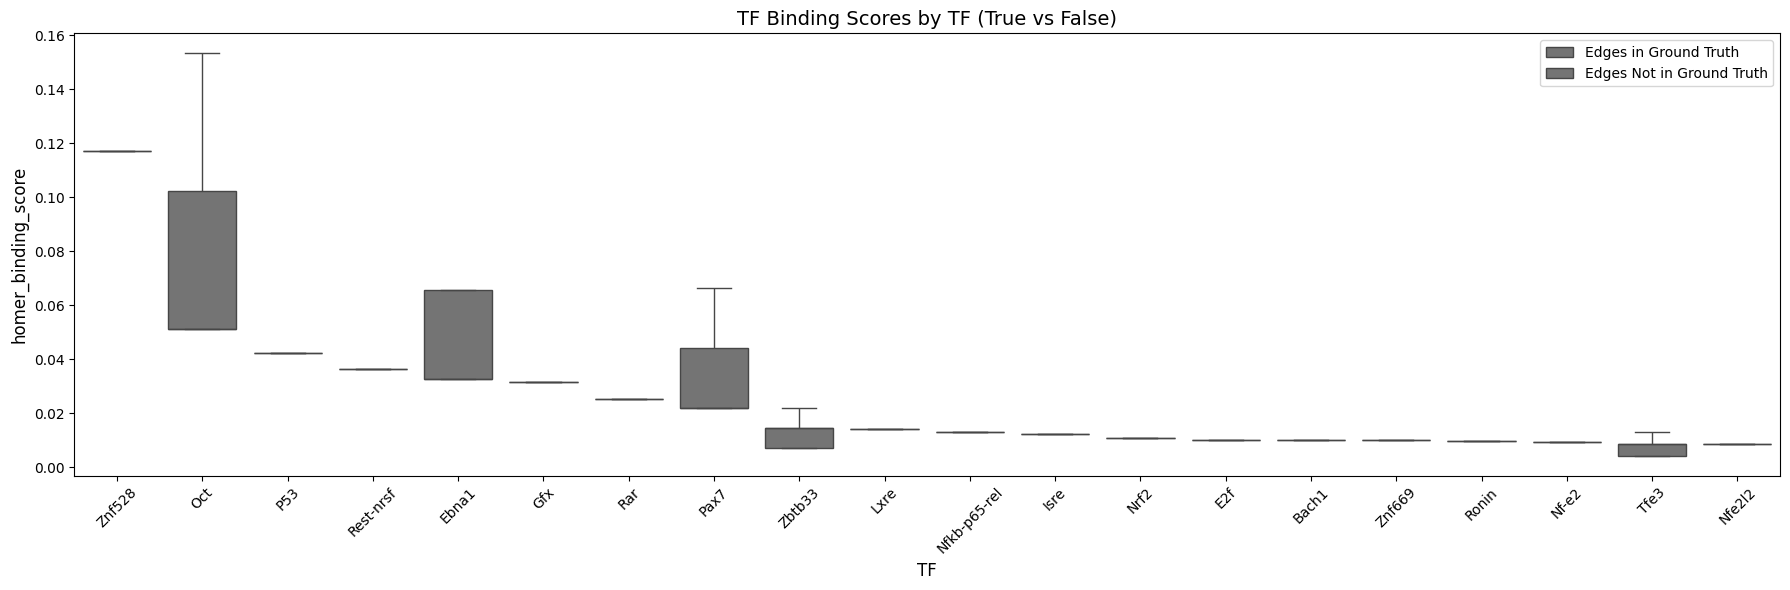

In [203]:
fig = dev_plots.plot_true_false_scores_by_tf_boxplots(
    df=selected_df,
    score_col=selected_score_col,
    tf_name_col=selected_method_tf_col,
    top_n=20,
    order_by="median",
)
fig.show()

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:247: FutureWarning: The provided callable <function median at 0x155299f0fb80> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  sub.groupby([tf_name_col, "label"])[score_col]
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:263: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


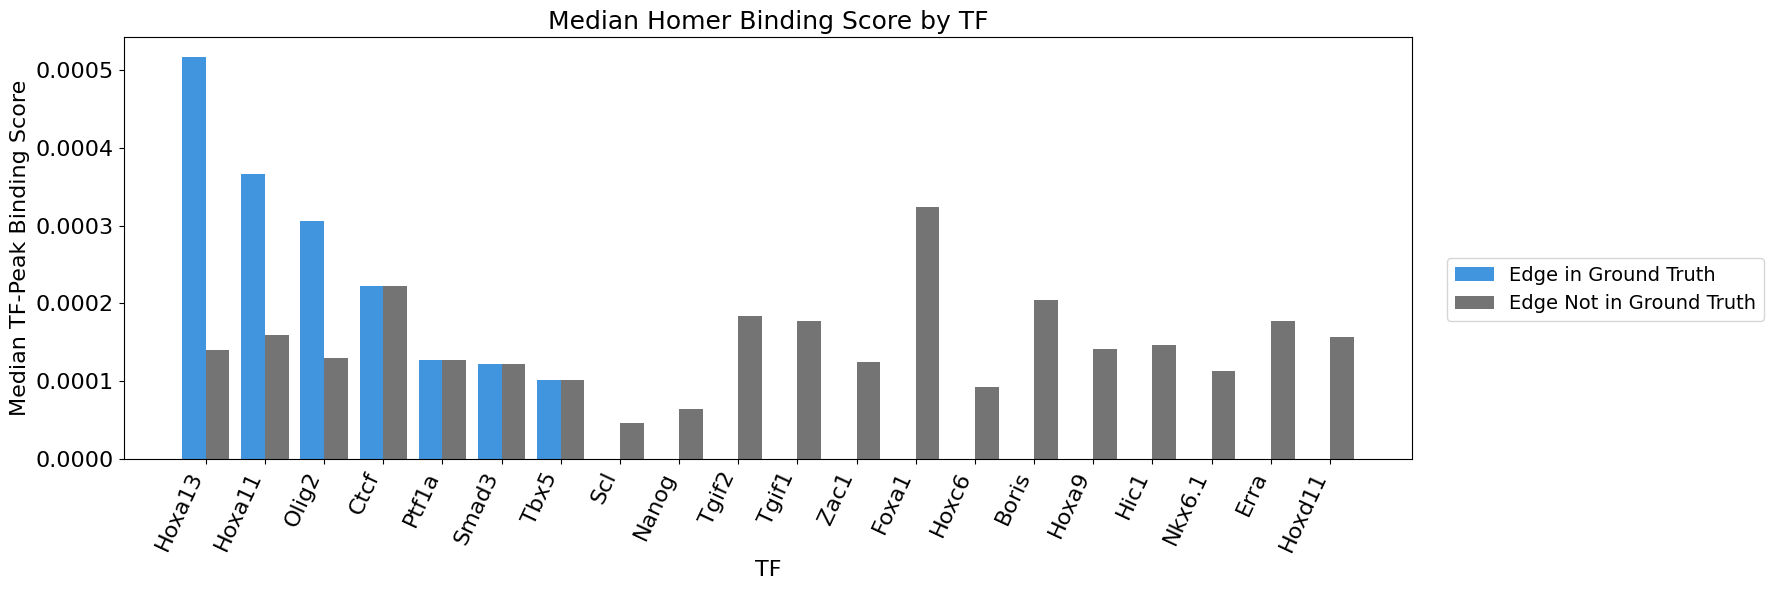

In [204]:
fig = dev_plots.plot_true_false_scores_by_tf_barplots(
    df=selected_df,
    score_col=selected_score_col,
    tf_name_col=selected_method_tf_col,
    title=f"Median {selected_method_name} Binding Score by TF"
)
fig.show()

In [205]:
from scipy.stats import linregress
from pandas.api.types import is_integer_dtype, is_bool_dtype, is_numeric_dtype
import math

from traitlets import default

def plot_distance_scatter_by_tf(
    df: pd.DataFrame,
    score_col: str,
    tf_col_name: str = "source_id",
    tfs_of_interest: list[str] = (),
    title: str = "",
    limit_x: Union[tuple[float, float], None] = None,
    max_panels: int = 9,
    log: bool = False,
):
    n = min(len(tfs_of_interest), 9)            # or your max_panels
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(rows*3, cols*3), layout="constrained")
    ax = np.atleast_1d(axes).ravel()

    # --- validations ---
    assert score_col in df.columns and tf_col_name in df.columns and "label" in df.columns
    assert is_bool_dtype(df["label"]) or is_integer_dtype(df["label"]), \
        f"'label' must be bool or integer-like, found {df['label'].dtype}"
    assert is_numeric_dtype(df["peak_length"]) and is_numeric_dtype(df[score_col])

    # iterate safely; stop after max_panels or list is exhausted
    nslots = rows * cols if max_panels is None else min(max_panels, rows * cols)
    num_plots = 0

    for tf in tfs_of_interest:
        if num_plots >= nslots:
            break

        tfs = df.loc[df[tf_col_name] == tf, ["peak_length", score_col, "label"]].dropna()
        if tfs.empty:
            continue

        is_true = tfs["label"].astype(bool)
        true_df  = tfs[is_true]
        false_df = tfs[~is_true]
        if (len(true_df) <= 10) or (len(false_df) <= 10):
            continue

        # Fit on TRUE group (as you had)
        slope, intercept, r, p, stderr = linregress(true_df["peak_length"], true_df[score_col])
        line_lab = f"r={r:.2f}, p-value={p:.2f}"

        # Balance counts for plotting clarity
        k = min(len(true_df), len(false_df))
        true_s  = true_df.sample(k, random_state=0)
        false_s = false_df.sample(k, random_state=0)

        a = ax[num_plots]
        a.scatter(false_s["peak_length"], false_s[score_col], s=28, c="#747474",
                  edgecolors="#2D2D2D", alpha=0.30, rasterized=True)
        a.scatter(true_s["peak_length"],  true_s[score_col],  s=28, c="#4195df",
                  edgecolors="#032b5f", alpha=0.90, rasterized=True)

        # Fit line across the observed x-range
        x0 = 0.0
        x1 = max(true_s["peak_length"].max(), false_s["peak_length"].max()) * 1.05
        xs = np.linspace(x0, x1, 200)
        a.plot(xs, intercept + slope * xs, c="black", lw=2, ls="--", label=line_lab)

        a.set_title(tf, fontsize=12)
        a.set_xlabel("Peak Length (bp)", fontsize=11)
        a.set_ylabel(score_col, fontsize=11)

        if log:
            a.set_yscale("log")

        if limit_x is not None:
            a.set_xlim(*limit_x)

        # Set legend to be at the bottom of each subplot
        leg = a.legend(bbox_to_anchor=(0.5, -0.35), loc="lower center",
                       borderaxespad=0.0, fontsize=9)

        num_plots += 1
    
    default_h_pad = 0.04167
    plt.rcParams["figure.constrained_layout.h_pad"] = default_h_pad
        
    # Set unused plots invisible
    for k in range(num_plots, len(ax)):
        ax[k].set_visible(False)

    if not title:
        title = "TF–Peak Binding Score vs Peak Length by TF"
    fig.suptitle(title, fontsize=14)

    return fig


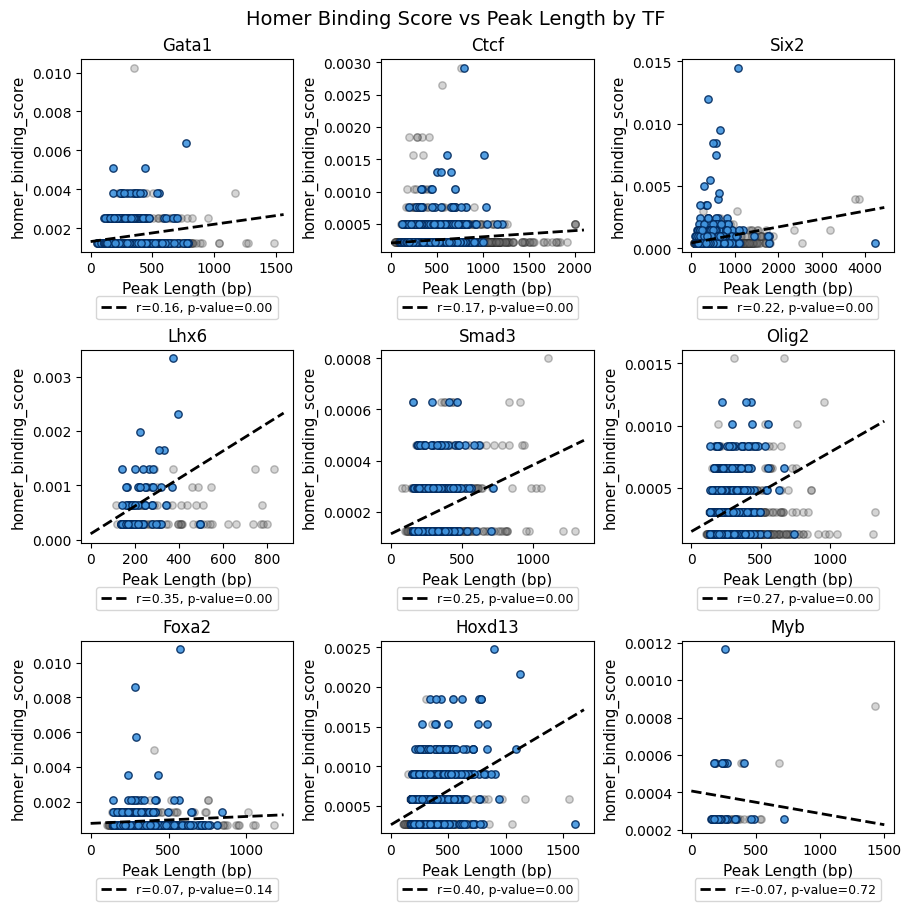

In [206]:
fig = plot_distance_scatter_by_tf(
    df=selected_df, 
    score_col=selected_score_col, 
    title=f"{selected_method_name} Binding Score vs Peak Length by TF",
    tf_col_name=selected_method_tf_col, 
    tfs_of_interest=selected_df[selected_method_tf_col].unique(), 
    )
fig.show()

In [ ]:
homer_tf_tg_sum_df = utils.calculate_summed_tf_tg_score(
    df=selected_df,
    score_col=selected_score_col,
    tf_col_name=selected_method_tf_col,
    )

homer_tf_peak_tg_df = utils.calculate_tf_peak_tg_score(
    df=selected_df,
    score_col=selected_score_col,
    tf_col_name=selected_method_tf_col
    )

homer_tf_tg_sum_merged_df = utils.merge_dataset_with_ground_truth(
    df=homer_tf_tg_sum_df,
    ground_truth=chip_atlas_edges_full,
    tf_col_name=selected_method_tf_col
)

homer_tf_peak_tg_merged_df = utils.merge_dataset_with_ground_truth(
    df=homer_tf_peak_tg_df,
    ground_truth=chip_atlas_edges_full,
    tf_col_name=selected_method_tf_col
)

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:730: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:730: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


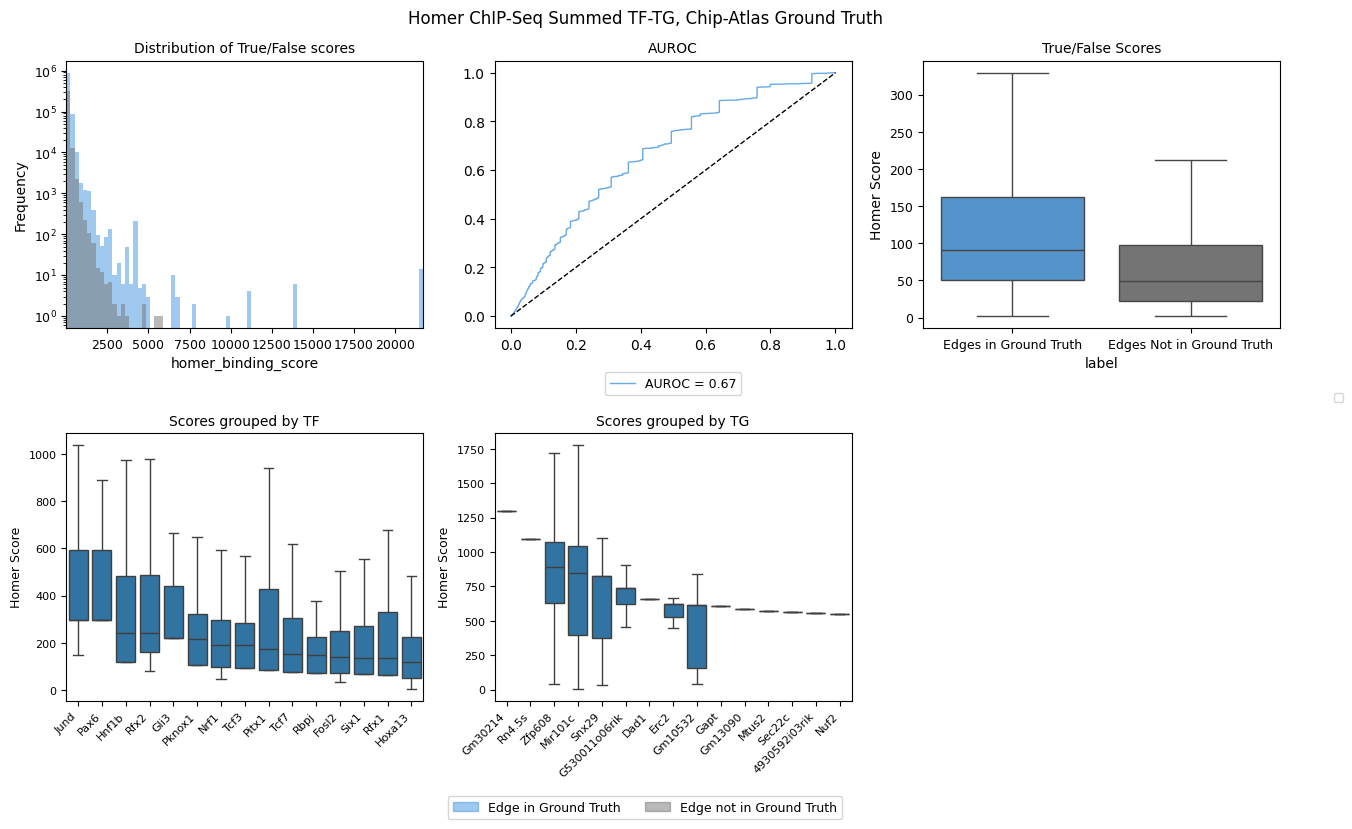

In [211]:
fig = dev_plots.plot_calculation_method_overview(
    chipseq_plot_df=homer_tf_tg_sum_merged_df,
    score_col=selected_score_col,
    tf_col_name=selected_method_tf_col,
    method_name=selected_method_name,
    log_dist=True
    )
fig.show()

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:730: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:730: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


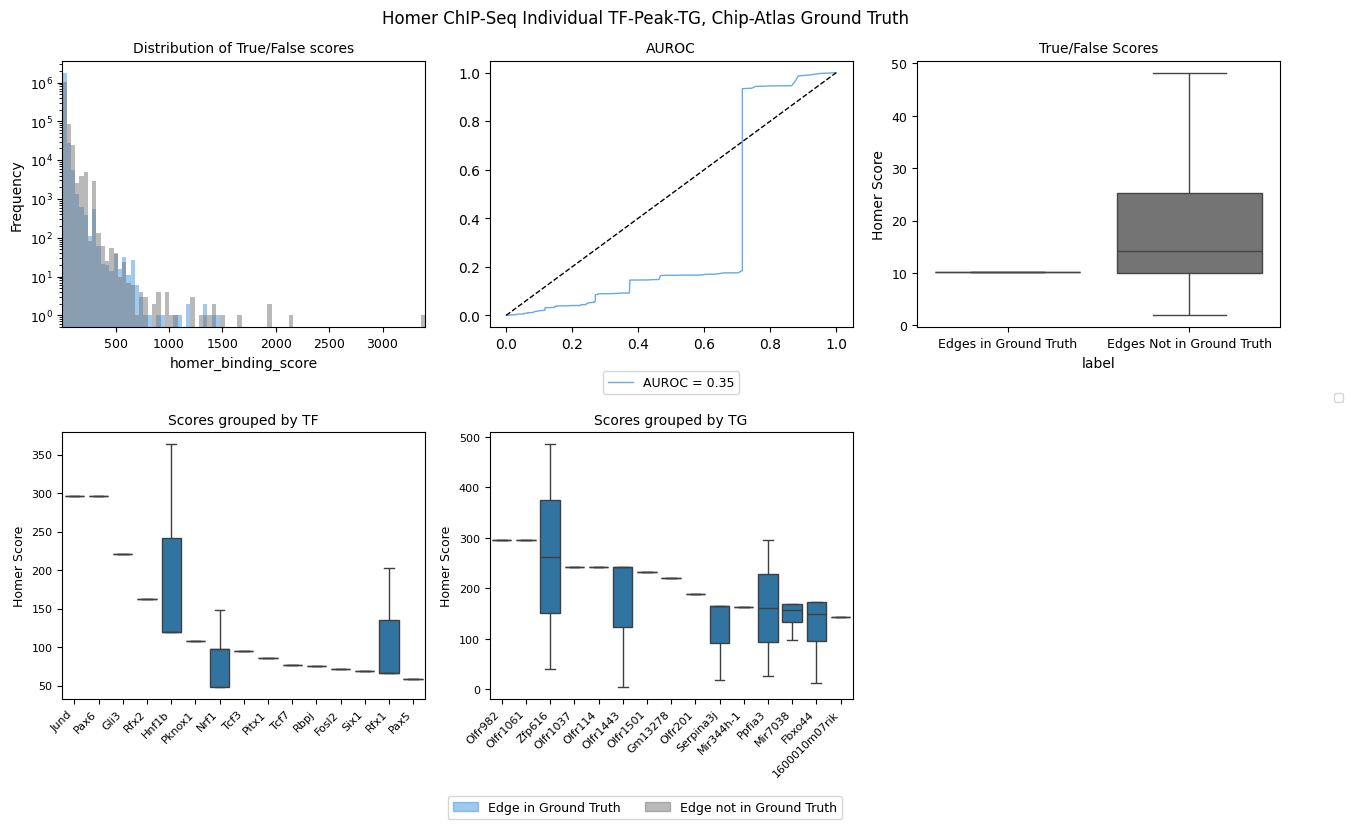

In [221]:
fig = dev_plots.plot_calculation_method_overview(
    chipseq_plot_df=homer_tf_peak_tg_merged_df,
    score_col=selected_score_col,
    tf_col_name=selected_method_tf_col,
    method_name=selected_method_name,
    calculation_method="Individual TF-Peak-TG",
    log_dist=True
    )
fig.show()

In [237]:
from scipy import stats
def calculate_difference_between_true_false_scores(df: pd.DataFrame, group_col: str, score_col: str, tf_col_name: str) -> pd.DataFrame:
    # Calculate the mean, stdev, and count of sliding window scores for each TF
    df = df.copy()
    df["label"] = df["label"].astype(bool)
    df_grouped = (
        df[[tf_col_name, "target_id", score_col, "label"]]
        .groupby([group_col, "label"])
        .agg(
            mean=(score_col, "mean"),
            stdev=(score_col, "std"), # Guards against taking the stderr of mean when only 1 score
            count=(score_col, "size")
            )
        .reset_index()
        .dropna()
    )

    # Separate the scores by label
    pivot_df = pd.pivot(
        data=df_grouped, 
        index=group_col, 
        columns="label", 
        values=["mean", "stdev", "count"],
        ).reset_index()
    
    # Flatten columns to strings (rather than multi index)
    pivot_df.columns = [
        f"{col1}_{col2}" if col2 != "" else str(col1)
        for col1, col2 in pivot_df.columns
    ]

    # Welch's t
    se_diff = np.sqrt((pivot_df["stdev_True"]**2)/pivot_df["count_True"] + (pivot_df["stdev_False"]**2)/pivot_df["count_False"])
    t_stat = (pivot_df["mean_True"] - pivot_df["mean_False"]) / se_diff

    # Welch-Satterthwaite df
    df_numerator = ((pivot_df["stdev_True"]**2)/pivot_df["count_True"] + (pivot_df["stdev_False"]**2)/pivot_df["count_False"])**2
    df_denominator = ((pivot_df["stdev_True"]**2)/pivot_df["count_True"])**2 / (pivot_df["count_True"]-1) + ((pivot_df["stdev_False"]**2)/pivot_df["count_False"])**2 / (pivot_df["count_False"]-1)

    df = df_numerator / df_denominator

    # two-tailed p-values
    p_val = 2 * stats.t.sf(np.abs(t_stat), df)

    pivot_df["t_stat"] = t_stat
    pivot_df["df"] = df
    pivot_df["p_value"] = p_val
    pivot_df["significant"] = p_val < 0.05

    # Sort by significance
    pivot_df = pivot_df.sort_values(by="p_value", ascending=True)
    
    pivot_df = pivot_df.dropna()
    
    return pivot_df

In [238]:
norm_selected_df = homer_tf_peak_tg_merged_df.copy()
norm_selected_df[selected_score_col] = np.log1p(norm_selected_df[selected_score_col])

selected_df_tf_mean_diff = calculate_difference_between_true_false_scores(
    norm_selected_df, 
    group_col=selected_method_tf_col,
    score_col=selected_score_col,
    tf_col_name=selected_method_tf_col
    )

In [235]:
importlib.reload(utils)
importlib.reload(dev_plots)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


INFO: Setting density=True balances the dataset, balance can be set to False


/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:438: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


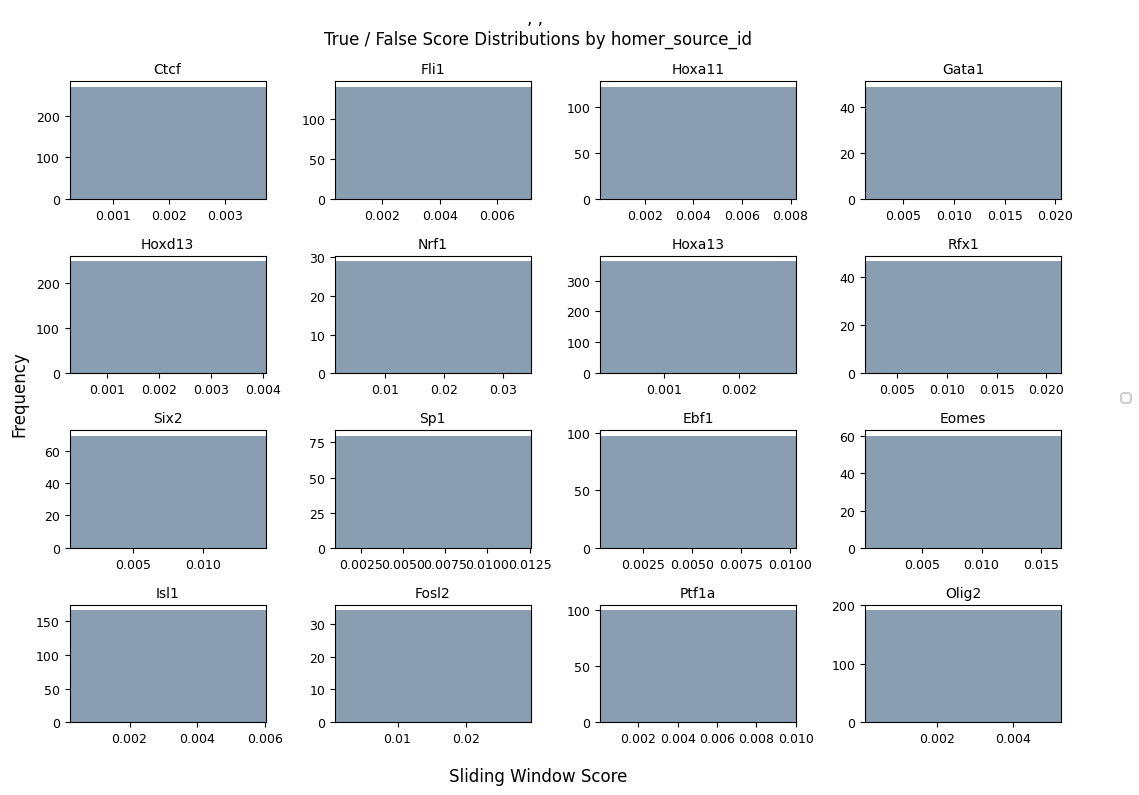

In [239]:
fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=selected_df_tf_mean_diff,
    original_score_df=selected_df,
    group_col=selected_method_tf_col,
    score_col=selected_score_col
)
fig.show()